In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.data_manipulation import transform_data_datetime

# London Rainfall Data

source: [Copernicous Climate Data Store](https://cds.climate.copernicus.eu/)

In [2]:
london_daily_data = pd.read_pickle('./output/tp/london/london_tp_daily_data.pkl')

In [3]:
london_daily_data.columns

Index(['date', 'year', 'month', 'day', 'tp_daily_sum', 'tp_daily_mean',
       'tp_daily_std', 'tp_daily_median', 'tp_daily_max', 'tp_daily_min',
       'tp_mm_daily_sum', 'tp_mm_daily_mean', 'tp_mm_daily_std',
       'tp_mm_daily_median', 'tp_mm_daily_min', 'tp_mm_daily_max', 'month_int',
       'rainy_day'],
      dtype='object')

In [4]:
df_london_day = london_daily_data[['date', 'year', 'month', 'day', 'tp_mm_daily_sum', 'month_int']].copy()

In [5]:
df_london_day['tp_mm'] = np.where(df_london_day['tp_mm_daily_sum'] > 0.1, np.round(df_london_day['tp_mm_daily_sum'],1), 0.0)

In [6]:
df_london_day[df_london_day['tp_mm_daily_sum'] > 0.05].sort_values('tp_mm_daily_sum')

,date,year,month,day,tp_mm_daily_sum,month_int,tp_mm
5883,2015-02-09,2015,Feb,9,0.050065,2,0.0
2531,2005-12-06,2005,Dec,6,0.050163,12,0.0
9646,2025-05-30,2025,May,30,0.050163,5,0.0
4183,2010-06-15,2010,Jun,15,0.050217,6,0.0
9116,2023-12-17,2023,Dec,17,0.050377,12,0.0
...,...,...,...,...,...,...,...
7465,2019-06-10,2019,Jun,10,29.865637,6,29.9
4620,2011-08-26,2011,Aug,26,29.940726,8,29.9
8328,2021-10-20,2021,Oct,20,30.453879,10,30.5
8204,2021-06-18,2021,Jun,18,31.266725,6,31.3


In [7]:
import calendar

monthly_precipitation = df_london_day.groupby(['year', 'month'])['tp_mm'].sum().reset_index()
monthly_precipitation.columns = ['year', 'month', 'monthly_total']

# Convert month to categorical for proper ordering
month_order = list(calendar.month_abbr)[1:]
monthly_precipitation['month'] = pd.Categorical(monthly_precipitation['month'], 
                                              categories=month_order, ordered=True)

# Calculate mean monthly precipitation across years
mean_monthly_precip = monthly_precipitation.groupby('month')['monthly_total'].mean().reset_index().rename(columns = {'monthly_total' : 'monthly_mean'})

mean_monthly_precip

,month,monthly_mean
0,Jan,59.966667
1,Feb,53.585185
2,Mar,48.807407
3,Apr,48.759259
4,May,59.885185
5,Jun,60.677778
6,Jul,65.165385
7,Aug,69.292308
8,Sep,49.053846
9,Oct,68.165385


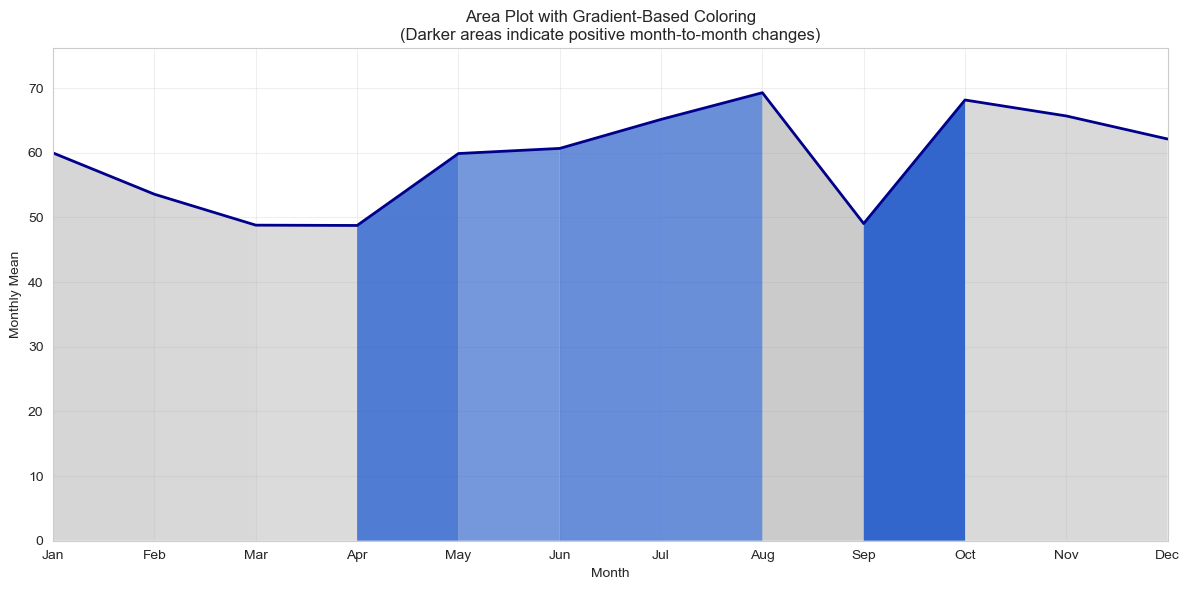

Month-to-Month Gradients:
   month  monthly_mean   gradient
0    Jan     59.966667   0.000000
1    Feb     53.585185  -6.381481
2    Mar     48.807407  -4.777778
3    Apr     48.759259  -0.048148
4    May     59.885185  11.125926
5    Jun     60.677778   0.792593
6    Jul     65.165385   4.487607
7    Aug     69.292308   4.126923
8    Sep     49.053846 -20.238462
9    Oct     68.165385  19.111538
10   Nov     65.696154  -2.469231
11   Dec     62.130769  -3.565385


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import PolyCollection

# Sample data (replace with your actual dataframe)
# Handling both string and numeric month formats

# Create numeric month values for plotting
if mean_monthly_precip['month'].dtype == 'category':  # String months
    mean_monthly_precip['month_num'] = range(len(mean_monthly_precip))
    month_labels = mean_monthly_precip['month'].tolist()
else:  # Numeric months
    mean_monthly_precip['month_num'] = mean_monthly_precip['month'] 
    month_labels = mean_monthly_precip['month'].tolist()

# Calculate the gradient (difference between consecutive months)
mean_monthly_precip['gradient'] = mean_monthly_precip['monthly_mean'].diff().fillna(0)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Define color map - darker for positive gradients
# Normalize gradients to [0, 1] range for color mapping
grad_norm = (mean_monthly_precip['gradient'] - mean_monthly_precip['gradient'].min()) / (mean_monthly_precip['gradient'].max() - mean_monthly_precip['gradient'].min())

# Create segments for the area plot
segments = []
colors = []

for i in range(len(mean_monthly_precip) - 1):
    # Create polygon for each segment using numeric month values
    x1, x2 = mean_monthly_precip['month_num'].iloc[i], mean_monthly_precip['month_num'].iloc[i + 1]
    y1, y2 = mean_monthly_precip['monthly_mean'].iloc[i], mean_monthly_precip['monthly_mean'].iloc[i + 1]
    
    # Create trapezoid segment
    segment = [(x1, 0), (x1, y1), (x2, y2), (x2, 0)]
    segments.append(segment)
    
    # Color based on gradient - darker for positive changes
    if mean_monthly_precip['gradient'].iloc[i + 1] > 0:
        # Positive gradient - use darker color
        alpha = 0.3 + 0.7 * grad_norm.iloc[i + 1]  # Range from 0.3 to 1.0
        colors.append((0.2, 0.4, 0.8, alpha))  # Blue with varying alpha
    else:
        # Negative or zero gradient - use lighter color
        alpha = 0.2 + 0.3 * (1 - abs(grad_norm.iloc[i + 1]))  # Lighter for negative
        colors.append((0.6, 0.6, 0.6, alpha))  # Gray with varying alpha

# Create the collection of polygons
poly_collection = PolyCollection(segments, facecolors=colors, edgecolors='none')
ax.add_collection(poly_collection)

# Add the line plot on top using numeric values
sns.lineplot(data=mean_monthly_precip, x='month_num', y='monthly_mean', ax=ax, color='darkblue', linewidth=2)

# Customize the plot
ax.set_xlim(mean_monthly_precip['month_num'].min(), mean_monthly_precip['month_num'].max())
ax.set_ylim(0, mean_monthly_precip['monthly_mean'].max() * 1.1)
ax.set_xlabel('Month')
ax.set_ylabel('Monthly Mean')

# Set custom month labels if they were strings
if mean_monthly_precip['month'].dtype == 'category':
    ax.set_xticks(mean_monthly_precip['month_num'])
    ax.set_xticklabels(month_labels)
ax.set_title('Area Plot with Gradient-Based Coloring\n(Darker areas indicate positive month-to-month changes)')

# Add grid for better readability
ax.grid(True, alpha=0.3)

# Set seaborn style
sns.set_style("whitegrid")

plt.tight_layout()
plt.show()

# # Alternative approach using fill_between with custom coloring
# fig, ax = plt.subplots(figsize=(12, 6))

# # Plot the basic area using numeric month values
# ax.fill_between(mean_monthly_precip['month_num'], mean_monthly_precip['monthly_mean'], alpha=0.2, color='lightblue')

# # Add colored segments based on gradient
# for i in range(len(mean_monthly_precip) - 1):
#     x_range = [mean_monthly_precip['month_num'].iloc[i], mean_monthly_precip['month_num'].iloc[i + 1]]
#     y_range = [mean_monthly_precip['monthly_mean'].iloc[i], mean_monthly_precip['monthly_mean'].iloc[i + 1]]
    
#     if mean_monthly_precip['gradient'].iloc[i + 1] > 0:
#         # Positive gradient - darker fill
#         intensity = min(mean_monthly_precip['gradient'].iloc[i + 1] / mean_monthly_precip['gradient'].max(), 1.0)
#         alpha = 0.3 + 0.6 * intensity
#         ax.fill_between(x_range, [0, 0], y_range, 
#                        color='darkblue', alpha=alpha, interpolate=True)

# # Add the line plot using numeric values
# sns.lineplot(data=mean_monthly_precip, x='month_num', y='monthly_mean', ax=ax, color='navy', linewidth=2)

# ax.set_xlabel('Month')
# ax.set_ylabel('Monthly Mean')
# ax.set_title('Alternative: Fill Between with Gradient Coloring')

# # Set custom month labels if they were strings
# if mean_monthly_precip['month'].dtype == 'object':
#     ax.set_xticks(mean_monthly_precip['month_num'])
#     ax.set_xticklabels(month_labels)

# ax.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # Print gradient information for reference
print("Month-to-Month Gradients:")
print(mean_monthly_precip[['month', 'monthly_mean', 'gradient']])

In [16]:
mean_monthly_precip['monthly_mean'].sum()

711.1853276353276

<Figure size 640x480 with 0 Axes>

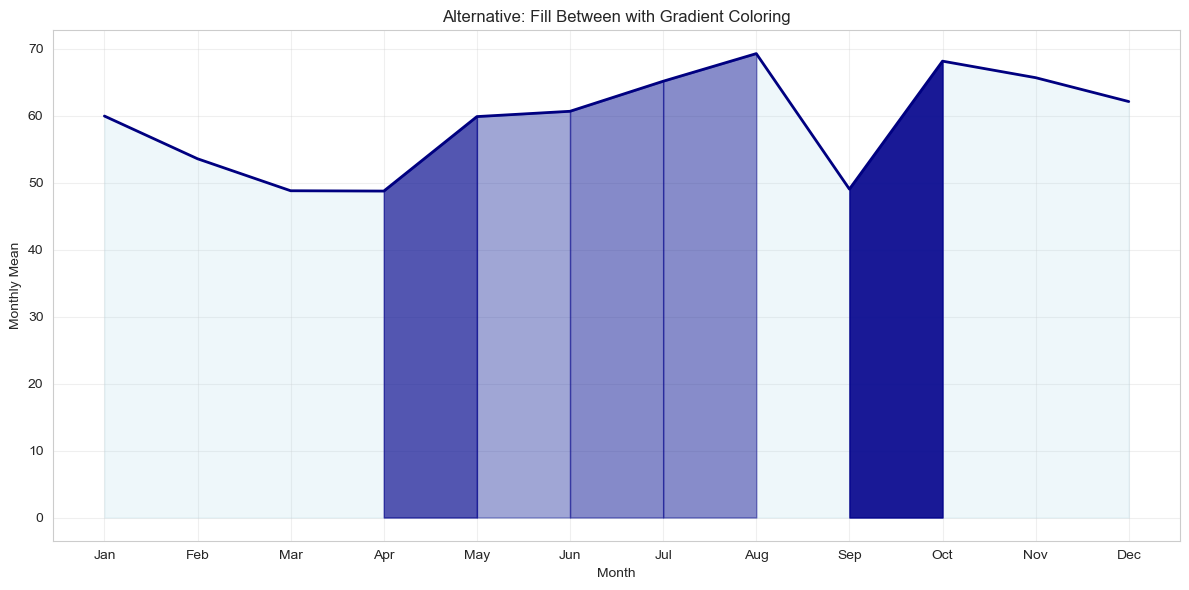

Month-to-Month Gradients:
   month  monthly_mean   gradient
0    Jan     59.966667   0.000000
1    Feb     53.585185  -6.381481
2    Mar     48.807407  -4.777778
3    Apr     48.759259  -0.048148
4    May     59.885185  11.125926
5    Jun     60.677778   0.792593
6    Jul     65.165385   4.487607
7    Aug     69.292308   4.126923
8    Sep     49.053846 -20.238462
9    Oct     68.165385  19.111538
10   Nov     65.696154  -2.469231
11   Dec     62.130769  -3.565385


In [45]:
# Set seaborn style
sns.set_style("whitegrid")

plt.tight_layout()
plt.show()

# Alternative approach using fill_between with custom coloring
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the basic area
ax.fill_between(mean_monthly_precip['month'], mean_monthly_precip['monthly_mean'], alpha=0.2, color='lightblue');

# Calculate the gradient (difference between consecutive months)
mean_monthly_precip['gradient'] = mean_monthly_precip['monthly_mean'].diff().fillna(0)
# Add colored segments based on gradient
for i in range(len(mean_monthly_precip) - 1):
    x_range = [mean_monthly_precip['month'].iloc[i], mean_monthly_precip['month'].iloc[i + 1]]
    y_range = [mean_monthly_precip['monthly_mean'].iloc[i], mean_monthly_precip['monthly_mean'].iloc[i + 1]]
    
    if mean_monthly_precip['gradient'].iloc[i + 1] > 0:
        # Positive gradient - darker fill
        intensity = min(mean_monthly_precip['gradient'].iloc[i + 1] / mean_monthly_precip['gradient'].max(), 1.0)
        alpha = 0.3 + 0.6 * intensity
        ax.fill_between(x_range, [0, 0], y_range, 
                       color='darkblue', alpha=alpha, interpolate=True)

# Add the line plot
sns.lineplot(data=mean_monthly_precip, x='month', y='monthly_mean', ax=ax, color='navy', linewidth=2)

ax.set_xlabel('Month')
ax.set_ylabel('Monthly Mean')
ax.set_title('Alternative: Fill Between with Gradient Coloring')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print gradient information for reference
print("Month-to-Month Gradients:")
print(mean_monthly_precip[['month', 'monthly_mean', 'gradient']]);

ValueError: could not convert string to float: 'Jan'

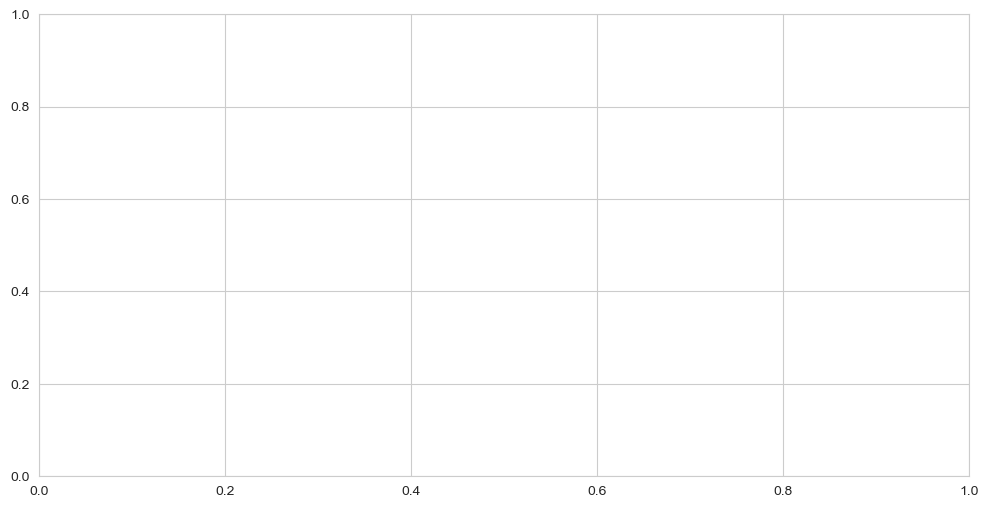

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import PolyCollection



# Calculate the gradient (difference between consecutive months)
# df['gradient'] = df['monthly_mean'].diff().fillna(0)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Define color map - darker for positive gradients
# Normalize gradients to [0, 1] range for color mapping
grad_norm = (mean_monthly_precip['gradient'] - mean_monthly_precip['gradient'].min()) / (mean_monthly_precip['gradient'].max() - mean_monthly_precip['gradient'].min())

# Create segments for the area plot
segments = []
colors = []

for i in range(len(mean_monthly_precip) - 1):
    # Create polygon for each segment
    x1, x2 = mean_monthly_precip['month'].iloc[i], mean_monthly_precip['month'].iloc[i + 1]
    y1, y2 = mean_monthly_precip['monthly_mean'].iloc[i], mean_monthly_precip['monthly_mean'].iloc[i + 1]
    
    # Create trapezoid segment
    segment = [(x1, 0), (x1, y1), (x2, y2), (x2, 0)]
    segments.append(segment)
    
    # Color based on gradient - darker for positive changes
    if mean_monthly_precip['gradient'].iloc[i + 1] > 0:
        # Positive gradient - use darker color
        alpha = 0.3 + 0.7 * grad_norm.iloc[i + 1]  # Range from 0.3 to 1.0
        colors.append((0.2, 0.4, 0.8, alpha))  # Blue with varying alpha
    else:
        # Negative or zero gradient - use lighter color
        alpha = 0.2 + 0.3 * (1 - abs(grad_norm.iloc[i + 1]))  # Lighter for negative
        colors.append((0.6, 0.6, 0.6, alpha))  # Gray with varying alpha

# Create the collection of polygons
poly_collection = PolyCollection(segments, facecolors=colors, edgecolors='none')
ax.add_collection(poly_collection)

# Add the line plot on top
sns.lineplot(data=mean_monthly_precip, x='month', y='monthly_mean', ax=ax, color='darkblue', linewidth=2)

# Customize the plot
ax.set_xlim(mean_monthly_precip['month'].min(), mean_monthly_precip['month'].max())
ax.set_ylim(0, mean_monthly_precip['monthly_mean'].max() * 1.1)
ax.set_xlabel('Month')
ax.set_ylabel('Monthly Mean')
ax.set_title('Area Plot with Gradient-Based Coloring\n(Darker areas indicate positive month-to-month changes)')

# Add grid for better readability
ax.grid(True, alpha=0.3)

# Set seaborn style
sns.set_style("whitegrid")

plt.tight_layout()
plt.show()

In [35]:
df_london_day_less = df_london_day[df_london_day['tp_mm_daily_sum'] <= 0.1].copy()

In [36]:
(df_london_day
 .groupby('year')['tp_mm_daily_sum']
 .sum()
)


year
1999    654.551079
2000    879.546671
2001    795.023448
2002    738.264118
2003    577.337717
2004    652.490024
2005    550.885330
2006    695.295085
2007    682.205960
2008    690.267652
2009    633.583636
2010    642.334462
2011    550.452896
2012    931.102272
2013    739.966754
2014    890.783657
2015    696.419839
2016    653.681747
2017    725.525923
2018    655.972695
2019    804.462838
2020    735.372368
2021    873.992582
2022    648.726870
2023    772.121934
2024    805.791914
2025    216.846684
Name: tp_mm_daily_sum, dtype: float64

In [37]:
(df_london_day_less
 .groupby('year')['tp_mm_daily_sum']
 .sum()
)


year
1999    2.074862
2000    2.346896
2001    2.129457
2002    2.771909
2003    3.033074
2004    2.586647
2005    2.797270
2006    2.349662
2007    2.765754
2008    1.972572
2009    2.721974
2010    2.633292
2011    3.223515
2012    2.398167
2013    2.796331
2014    2.266273
2015    2.678552
2016    2.647158
2017    1.940023
2018    3.335368
2019    2.312270
2020    1.977698
2021    2.402929
2022    2.132332
2023    2.434090
2024    2.041377
2025    1.558680
Name: tp_mm_daily_sum, dtype: float64

In [ ]:
# Hampstead 51.55338143494524, -0.1778743735609532

data = pd.read_csv('./output/london_weather_dataBACKUP.csv')
data.head()

In [ ]:
# data['datetime'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')
data['valid_datetime'] = pd.to_datetime(data['valid_time'], format='%Y-%m-%d %H:%M:%S')


In [ ]:
data.sort_values(by='valid_datetime', inplace=True)
data.reset_index(drop=True, inplace=True)

In [ ]:
data.head(5)

In [ ]:
data['year'] = data['valid_datetime'].dt.year
# data['month int'] = data['valid_datetime'].dt.month
# data['day'] = data['valid_datetime'].dt.day
# data['month'] = data['valid_datetime'].dt.strftime('%b')
# data['month'] = pd.Categorical(data['month'], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
#                                                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)

In [ ]:
data['RR_mm'] = data['tp'] * 1000

yearly_agg = (data[(data['year'] > 2021) &(data['year'] < 2025)]
              .groupby(['year'], observed=True)
              .agg(
                  RR_mm_total = ('RR_mm', 'sum'),
                  RR_mm_median = ('RR_mm', 'median'),
                  RR_mm_mean = ('RR_mm', 'mean'),
                  RR_mm_max = ('RR_mm', 'max'),
                  RR_mm_min = ('RR_mm', 'min'),
                  )
                  .reset_index()
                  )

yearly_agg.head()

In [ ]:
data['DATE'] = data['valid_datetime'].dt.date


In [ ]:
daily_total_precipitation = (data[(data['year'] > 2021) &(data['year'] < 2025)]
 .groupby('DATE', observed=True)
 .agg(
     RR_daily_total=('RR_mm', 'sum'),
     RR_daily_max=('RR_mm', 'max'),
     )
     .reset_index()
)

In [ ]:
# daily_total_precipitation = transform_data_datetime(daily_total_precipitation)

In [ ]:
daily_total_precipitation['year'].unique()

In [ ]:
daily_total_precipitation.head()

### London New Source

- [Copernicus Reanalysis](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-timeseries?tab=overview)

In [ ]:
# creating a function transforming the data format in a more
# convenient way for furhter analysis

# steps
## valid_time -> datetime
## tp -> RR_mm

def transform_data_to_complete_dataset(df):
    '''
    First step in transforming raw data
    it takes the dataframe and creates a new dataframe with the following columns:
    - valid_time: datetime object
    - RR_mm: precipitation in mm (converted from tp)
    - t2m_celsius: temperature in Celsius (converted from t2m)
    '''
    df = df.copy()
    df['valid_time'] = pd.to_datetime(df['valid_time'], format='%Y-%m-%d %H:%M:%S')
    df['valid_datetime'] = df['valid_time'].dt.date
    
    df.sort_values(by='valid_time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df['RR_mm'] = df['tp'] * 1000  # Convert tp from m to mm
    df['t2m_celsius'] = df['t2m'] - 273.15  # Convert temperature from Kelvin to Celsius
    df.sort_values(by='valid_time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df[['valid_time', 'valid_datetime', 'RR_mm', 't2m_celsius', 'tp', 't2m', 'longitude', 'latitude']]

In [ ]:
def create_daily_aggregated_dataset(df, start_year = 0, end_year = 9999):
    if start_year == 0:
        start_year = df['valid_time'].min().year
    if end_year == 9999:
        end_year = df['valid_time'].max().year
    df = df[df['valid_time'].dt.year.between(start_year, end_year)]
    df_daily = df.groupby('valid_datetime').agg(
        valid_time=('valid_time', 'first'),
        RR_mm=('RR_mm', 'sum'),
        t2m_celsius_mean=('t2m_celsius', 'mean'),
        t2m_celsius_min=('t2m_celsius', 'min'),
        t2m_celsius_max=('t2m_celsius', 'max'),
        longitude=('longitude', 'first'),
        latitude=('latitude', 'first')
        ).reset_index().round(2)
    return df_daily

In [ ]:
def transform_data_datetime_test(df, date_column='DATE', datetime_format=True):   
    df = df.copy()
    if datetime_format:
        df['year'] = df[date_column].dt.year
        df['month int'] = df[date_column].dt.month
        df['month'] = df[date_column].dt.strftime('%b')
        df['day'] = df[date_column].dt.day

        return df
    # df['datetime'] = pd.to_datetime(df[date_column], format="%Y%m%d")
    df['datetime'] = pd.to_datetime(df[date_column], format="%Y%m%d")
    df['year'] = df['datetime'].dt.year
    df['month int'] = df['datetime'].dt.month
    df['month'] = df['datetime'].dt.strftime('%b')
    df['day'] = df['datetime'].dt.day

    return df[['datetime', 'valid_time', 'year', 'month','day','RR_mm', 't2m_celsius_mean', 't2m_celsius_min', 't2m_celsius_max', 'month int', 'longitude', 'latitude']]

In [ ]:
#  reanalysis-era5-single-levels-timeseries-london.csv

london_data = pd.read_csv('./data/reanalysis-era5-single-levels-timeseries-london.csv')
print(london_data.shape)
london_data.tail()

In [ ]:
london_data[london_data['tp'].isna()]

In [ ]:
df_london = transform_data_to_complete_dataset(london_data)

In [ ]:
df_london.head()

In [ ]:
daily_aggregate_london = create_daily_aggregated_dataset(df_london, start_year=1960)

In [ ]:
daily_aggregate_london = transform_data_datetime_test(daily_aggregate_london, date_column='valid_time', datetime_format=False)

In [ ]:
london_yearly_aggregate = (daily_aggregate_london
                           .groupby(['year'])
                           .agg(
                               RR_yearly_sum=('RR_mm', 'sum'),
                               t2m_celsius_yearly_mean=('t2m_celsius_mean', 'mean'),
                               t2m_celsius_yearly_min=('t2m_celsius_min', 'min'),
                               t2m_celsius_yearly_max=('t2m_celsius_max', 'max')
                               ).reset_index()
                               )


In [ ]:
london_yearly_aggregate.head()

In [ ]:
from src.data_plotting import plot_rainfall
plot_rainfall(london_yearly_aggregate,
              start_year=1960,latest_year=2025,feature='RR_yearly_sum',
              special_year=2026, title_label='Total Rainfall in London (1960-2024)',
              rotation_x_label=70,
              fig_size=(14,8))

In [ ]:
data.head()